# LangGraph 101: Building Your First Agent

Welcome to LangGraph 101! This notebook will walk you through the core concepts of building agents with LangChain and LangGraph.

**What you'll learn:**
- How to interact with language models
- Working with messages and conversation
- Adding tools to extend LLM capabilities
- Building an agent that can reason and act
- Adding memory to maintain context
- Streaming responses for better UX
<br> 
<br> 
---
<br> 

> **Note:** This tutorial uses LangChain v1 (alpha), which provides the easiest way to start building with LLMs. LangChain agents are built on top of LangGraph, providing durable execution, streaming, human-in-the-loop, and persistence out of the box.

## Part 0: Setup & Installation

First, let's install the necessary packages and set up our environment.

In [1]:
# Install required packages
# !pip install --pre -U langchain langchain-anthropic langchain-openai python-dotenv

In [3]:
# Load environment variables
from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env", override=True)

# We'll use OpenAI in this tutorial, but you can swap to any provider!
# Supported providers: OpenAI, Anthropic, Google, Cohere, and many more
# Using Claude Sonnet 4

False

## Part 1: Your First LLM Call

LangChain provides a **standard model interface** that works across all providers. This means you can easily swap between OpenAI, Anthropic, Google, and other providers without changing your code.

Let's start by initializing a chat model.

In [7]:
from langchain.chat_models import init_chat_model

# Initialize a chat model - you can easily swap providers!
# Examples: "openai:gpt-4o-mini", "anthropic:claude-sonnet-4-20250514", "google:gemini-2.0-flash"

# OpenAI (commented out)
# model = init_chat_model("openai:gpt-4o-mini")

# Claude Sonnet 4 - Fast and efficient
model = init_chat_model("anthropic:claude-sonnet-4-20250514")

# Make your first call!
response = model.invoke("What is LangChain?")
response.pretty_print()

================================== Ai Message ==================================

LangChain is an open-source framework designed to simplify the development of applications powered by large language models (LLMs). Here are its key aspects:

## Core Purpose
LangChain helps developers build complex AI applications by providing tools and abstractions that make it easier to work with LLMs like GPT, Claude, or open-source models.

## Key Features

**1. Chains & Sequences**
- Link multiple LLM calls and operations together
- Create workflows that process information step-by-step

**2. Prompt Management**
- Templates and tools for crafting effective prompts
- Dynamic prompt generation based on context

**3. Memory & Context**
- Maintain conversation history and context across interactions
- Different memory types for various use cases

**4. Data Integration**
- Connect to various data sources (databases, APIs, documents)
- Load, process, and query different types of content

**5. Agents & Too

### Key Takeaway:
- `init_chat_model()` gives you a standardized interface to any LLM provider
- `.invoke()` sends a message and returns a response
- No provider lock-in - swap models easily!

## Part 2: Understanding Messages

**Messages** are the fundamental unit of context for models in LangChain. They represent the input and output of models, carrying both content and metadata.

There are different message types:
- **SystemMessage** - Instructions for how the model should behave
- **HumanMessage** - User input
- **AIMessage** - Model responses
- **ToolMessage** - Results from tool executions

In [8]:
from langchain.messages import HumanMessage, SystemMessage, AIMessage

# Create a conversation with different message types
messages = [
    SystemMessage(content="You are a helpful AI assistant that explains technical concepts simply."),
    HumanMessage(content="What is an agent?"),
]

response = model.invoke(messages)
response.pretty_print()

================================== Ai Message ==================================

The term "agent" can mean different things depending on the context, but here are the main ways it's used:

## In General
An **agent** is someone or something that acts on behalf of another person, organization, or system to perform tasks or make decisions.

## Common Types of Agents

**Human Agents:**
- Real estate agents (help buy/sell properties)
- Travel agents (book trips and accommodations)
- Insurance agents (sell policies and handle claims)
- Sports agents (represent athletes in negotiations)

**AI/Software Agents:**
- Virtual assistants like Siri or Alexa
- Chatbots that handle customer service
- Automated trading programs
- Web crawlers that gather information

**In Technology:**
An agent is typically a program or system that:
- Operates independently
- Makes decisions based on its environment
- Works toward specific goals
- Can learn and adapt

The key idea is that agents have some level of **a

### Multi-turn Conversations

Messages make it easy to maintain conversation history:

In [9]:
# Continue the conversation
messages.append(response)  # Add AI response to history
messages.append(HumanMessage(content="Can you give me an example?"))

response = model.invoke(messages)
response.pretty_print()

================================== Ai Message ==================================

Sure! Let me give you a concrete example of a **software agent**:

## Example: A Smart Thermostat Agent

Imagine you have a smart thermostat in your home. This thermostat acts as an **agent** because it:

**Works independently:**
- It monitors the temperature 24/7 without you having to check it
- It automatically adjusts heating/cooling based on your preferences

**Makes decisions:**
- "It's getting hot and sunny - I'll turn on the AC before the house gets too warm"
- "Nobody's been home for 2 hours - I'll switch to energy-saving mode"

**Has goals:**
- Keep you comfortable
- Save energy when possible
- Learn your preferences over time

**Adapts and learns:**
- Notices you always turn the heat up when you get home at 6 PM
- Learns that you prefer it cooler on weekends when you're home all day
- Adjusts based on weather forecasts

**Acts on your behalf:**
- You don't have to constantly adjust it manually
-

### Key Takeaway:
- Messages represent the conversation history
- SystemMessage sets the model's behavior
- Build multi-turn conversations by appending messages to a list

## Part 3: Adding Tools - Extending LLM Capabilities

LLMs are great at language, but they can't access external data or perform actions. **Tools** extend their capabilities. You can give an LLM a list of tools, and when it needs one, it will specify which tool to call. Your job is to execute the tool and feed the results back to the LLM so it can decide what to do next.

You can create a tool just by writing a Python function with a clear description. LangChain's `@tool` decorator handles formatting the function's information in the LLM's desired format.  

Let's create some simple tools:

In [16]:
import requests
import json

from langchain_core.tools import tool


# Basic hardcoded tool
@tool
def search_movies(genre: str) -> str:
    """Search for movies by genre."""
    # In a real app, this would query a movie database
    movies = {
        "sci-fi": "Dune, Interstellar, Blade Runner 2049",
        "comedy": "The Grand Budapest Hotel, Superbad, Knives Out",
        "action": "Mad Max: Fury Road, John Wick, Mission Impossible"
    }
    return movies.get(genre.lower(), "No movies found for that genre")

# More realistic tool that calls an API
@tool
def get_weather(latitude: float, longitude: float) -> str:
    """Get current temperature in Celsius and weather code for given coordinates.

    Args:
        latitude: Latitude coordinate
        longitude: Longitude coordinate

    Returns:
        JSON string with temperature_celsius and weather_code (temperature is in Celsius, translate weather_code to plain English)
    """
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "current": "temperature_2m,weather_code",
        "temperature_unit": "celsius"
    }

    weather = requests.get(url, params=params).json()["current"]
    temperature = weather["temperature_2m"]
    weather_code = weather["weather_code"]
    result = {
        "temperature_celsius": temperature,
        "weather_code": weather_code
    }

    return json.dumps(result)



# Test a tool directly with SF's coordinates
print(get_weather.invoke({"latitude": 37.77, "longitude": 122.42}))

{"temperature_celsius": 16.0, "weather_code": 3}


### Tool Calling (Function Calling)

Now let's give these tools to the model using `.bind_tools()`:

In [17]:
# Bind tools to the model
tools = [get_weather, search_movies]
model_with_tools = model.bind_tools(tools)
message = "What's the weather like in Seattle?"

# The model can now decide to call tools
response = model_with_tools.invoke(message)

# Check if the model wants to call a tool
print("Tool calls:", response.tool_calls)

Tool calls: [{'name': 'get_weather', 'args': {'latitude': 47.6062, 'longitude': -122.3321}, 'id': 'toolu_01QXhYrZZLS9e2oYjetrq6iU', 'type': 'tool_call'}]


The model returns a **tool call** request with:
- `name`: Which tool to call
- `args`: Arguments to pass to the tool
- `id`: Unique identifier for tracking

Let's execute the tool and continue the conversation:

In [18]:
from langchain.messages import ToolMessage

# Execute the tool call
if response.tool_calls:
    tool_call = response.tool_calls[0]
    
    # Call the actual tool
    if tool_call["name"] == "get_weather":
        result = get_weather.invoke(tool_call["args"])

    elif tool_call["name"] == "search_movies":
        result = search_movies.invoke(tool_call["args"])
    
    # Create a ToolMessage with the result
    tool_message = ToolMessage(
        content=result,
        tool_call_id=tool_call["id"]
    )
    
    # Continue the conversation with the tool result
    final_response = model_with_tools.invoke([
        HumanMessage(content=message),
        response,
        tool_message
    ])
    
    final_response.pretty_print()

================================== Ai Message ==================================

The current weather in Seattle is:
- **Temperature**: 5.8°C (about 42°F)
- **Conditions**: Overcast (weather code 3 indicates overcast skies)

It's quite cool and cloudy in Seattle right now. You might want to dress warmly if you're heading out!


### Key Takeaway:
- Tools are Python functions decorated with `@tool`
- Good descriptions help the model know when to use each tool
- Tool calling flow: Model requests tool → Execute tool → Return result → Model synthesizes final response

## Part 4: Building Your First Agent with `create_agent()`

Manually defining a specific sequence of LLM calls and tool calls is tedious and inflexible. Instead, we can use an **agent** that runs this loop:
1. Model decides which tool to call (if any)
2. Tool gets executed
3. Result goes back to model
4. Repeat until task is complete

LangChain makes this easy with `create_agent()` - **build an agent in ~10 lines of code!**
The prebuilt agent handles running the loop described above - you just specify the system prompt and tools. 

In [19]:
from langchain.agents import create_agent

# Create an agent with tools
agent = create_agent(
    # model="openai:gpt-4o-mini",  # OpenAI (commented out)
    model="anthropic:claude-sonnet-4-20250514",  # Claude Sonnet 4 - Fast and efficient
    tools=[get_weather, search_movies],
    system_prompt="You are a helpful assistant that can check weather and recommend movies."
)

# Use the agent
result = agent.invoke({
    "messages": [HumanMessage(content="What's the weather in NYC? Also recommend some sci-fi movies.")]
})

# Print the final response
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

What's the weather in NYC? Also recommend some sci-fi movies.
================================== Ai Message ==================================

[{'text': "I'll help you get the weather for NYC and recommend some sci-fi movies!", 'type': 'text'}, {'id': 'toolu_01Cr5zUNUwFRdBG8gpgNbSaM', 'input': {'latitude': 40.7128, 'longitude': -74.006}, 'name': 'get_weather', 'type': 'tool_use'}, {'id': 'toolu_01BveNXdxEC8chWqExcx5gGo', 'input': {'genre': 'sci-fi'}, 'name': 'search_movies', 'type': 'tool_use'}]
Tool Calls:
  get_weather (toolu_01Cr5zUNUwFRdBG8gpgNbSaM)
 Call ID: toolu_01Cr5zUNUwFRdBG8gpgNbSaM
  Args:
    latitude: 40.7128
    longitude: -74.006
  search_movies (toolu_01BveNXdxEC8chWqExcx5gGo)
 Call ID: toolu_01BveNXdxEC8chWqExcx5gGo
  Args:
    genre: sci-fi
================================= Tool Message =================================
Name: get_weather

{"temperature_celsius": 14.5, "weather_code": 3

### What just happened?

The agent automatically:
1. Analyzed the user's request
2. Called `get_weather("NYC")`
3. Called `search_movies("sci-fi")`
4. Synthesized the results into a natural response

Let's visualize the agent's structure:

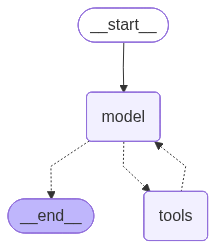

In [20]:
agent

### Key Takeaway:
- `create_agent()` builds a complete agent in ~10 lines
- The agent automatically handles the reasoning → action → observation loop
- Built on LangGraph for production features (persistence, streaming, human-in-the-loop)

## Part 5: Adding Memory & State

Right now, each agent invocation is independent. Let's add **memory** so the agent can maintain context across multiple interactions.

LangGraph uses **checkpointers** to save and restore state:

In [24]:
from langgraph.checkpoint.memory import MemorySaver
import uuid

# Create a checkpointer for memory
checkpointer = MemorySaver()

# Create an agent with memory
agent_with_memory = create_agent(
    # model="openai:gpt-4o-mini",  # OpenAI (commented out)
    model="anthropic:claude-sonnet-4-20250514",  # Claude Sonnet 4 - Fast and efficient
    tools=[get_weather, search_movies],
    system_prompt="You are a helpful assistant.",
    checkpointer=checkpointer
)

# Create a thread for this conversation
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

# First interaction
result1 = agent_with_memory.invoke(
    {"messages": [{"role": "user", "content": "My name is Dimitar and I love sci-fi movies."}]},
    config=config
)

print("Response 1:", result1["messages"][-1].content)

# Second interaction - the agent remembers!
result2 = agent_with_memory.invoke(
    {"messages": [{"role": "user", "content": "What's my name and what movies do I like?"}]},
    config=config
)
print("\nResponse 2:", result2["messages"][-1].content)

Response 1: Here are some great sci-fi movies you might enjoy:

1. **Dune** - An epic space opera based on Frank Herbert's classic novel
2. **Interstellar** - A mind-bending film about space exploration and time dilation
3. **Blade Runner 2049** - A visually stunning sequel to the cyberpunk classic

Have you seen any of these? Would you like me to search for any other specific type of sci-fi movies, or is there anything else I can help you with?

Response 2: Your name is Dimitar and you love sci-fi movies! 

Earlier you mentioned that you love sci-fi movies, and I found some great sci-fi films for you: Dune, Interstellar, and Blade Runner 2049. Is there anything specific about sci-fi movies you'd like to explore further, or would you like me to help you with something else?

Response 2: Your name is Dimitar and you love sci-fi movies! 

Earlier you mentioned that you love sci-fi movies, and I found some great sci-fi films for you: Dune, Interstellar, and Blade Runner 2049. Is there any

### Understanding State & Threads

- **State**: The agent's "memory" - includes message history and any custom data
- **Thread**: A conversation session identified by `thread_id`
- **Checkpointer**: Saves state after each step, enabling memory and error recovery

Each thread is independent:

In [25]:
# New thread - agent won't remember Alice
new_thread_id = str(uuid.uuid4())
new_config = {"configurable": {"thread_id": new_thread_id}}

result3 = agent_with_memory.invoke(
    {"messages": [{"role": "user", "content": "What's my name?"}]},
    config=new_config
)
print("New thread response:", result3["messages"][-1].content)

New thread response: I don't have access to information about your name. I can only see our current conversation, and you haven't told me your name yet. If you'd like me to know your name, please feel free to share it with me!

Is there anything else I can help you with? I have tools available to check weather conditions or search for movies by genre if you're interested in either of those.


### Key Takeaway:
- Checkpointers enable memory across interactions
- Thread IDs separate different conversations
- State persists automatically - no manual state management needed!

## Part 6: Streaming for Better UX

LLMs can take a while to respond. **Streaming** shows progress in real-time, dramatically improving user experience.

LangChain supports multiple streaming modes:

### Streaming Agent Steps

In [26]:
# Stream agent progress with stream_mode="updates"
print("Streaming agent steps:\n")

for chunk in agent.stream(
    {"messages": [{"role": "user", "content": "What's the weather in Boston?"}]},
    stream_mode="updates"
):
    for node_name, data in chunk.items():
        print(f"Step: {node_name}")
        if "messages" in data:
            message = data["messages"][-1]
            if hasattr(message, 'tool_calls') and message.tool_calls:
                print(f"   Tool call: {message.tool_calls[0]['name']}")
            elif hasattr(message, 'content'):
                print(f"   Content: {message.content[:100]}..." if len(message.content) > 100 else f"   Content: {message.content}")
        print()

Streaming agent steps:

Step: model
   Tool call: get_weather

Step: model
   Tool call: get_weather

Step: tools
   Content: {"temperature_celsius": 11.9, "weather_code": 3}

Step: tools
   Content: {"temperature_celsius": 11.9, "weather_code": 3}

Step: model
   Content: The current weather in Boston is 11.9°C (about 53°F) with overcast skies (weather code 3 indicates o...

Step: model
   Content: The current weather in Boston is 11.9°C (about 53°F) with overcast skies (weather code 3 indicates o...



### Streaming LLM Tokens

For a ChatGPT-like experience, stream tokens as they're generated:

In [28]:
# Stream tokens with stream_mode="messages"
print("Streaming tokens:\n")

for token, metadata in agent.stream(
    {"messages": [{"role": "user", "content": "Tell me about LangGraph in one sentence."}]},
    stream_mode="messages"
):
    # Only print content from the agent node
    if metadata.get('langgraph_node') == 'agent':
        # Get text from content blocks
        for block in token.content_blocks:
            if block.get('type') == 'text' and block.get('text'):
                print(block['text'], end='', flush=True)

print("\n")  # New line at the end

Streaming tokens:







### Key Takeaway:
- `stream_mode="updates"` - See each agent step (useful for debugging)
- `stream_mode="messages"` - Stream LLM tokens (ChatGPT-like UX)
- Streaming is built-in - no extra setup required!

## Part 7: Putting It All Together - A Practical Example

Let's build a more realistic agent that combines everything we've learned:

In [31]:
# Create more realistic tools
@tool
def get_user_preferences(user_id: str) -> str:
    """Get a user's saved preferences."""
    # Simulate a user database
    preferences = {
        "dimitar": "Loves sci-fi movies, prefers warm weather destinations",
        "bob": "Enjoys comedy films, likes cold climates for travel"
    }
    return preferences.get(user_id.lower(), "No preferences found")

@tool
def book_recommendation(genre: str, user_preferences: str = "") -> str:
    """Get personalized movie recommendations based on genre and user preferences."""
    recommendations = {
        "sci-fi": "Based on your preferences, try: Arrival, Ex Machina, or The Martian",
        "comedy": "Based on your preferences, try: The Big Lebowski, Anchorman, or Bridesmaids"
    }
    return recommendations.get(genre.lower(), "No recommendations available")

# Create a helpful assistant agent
assistant = create_agent(
    # model="openai:gpt-4o-mini",  # OpenAI (commented out)
    model="anthropic:claude-sonnet-4-20250514",  # Claude Sonnet 4 - Fast and efficient
    tools=[get_weather, get_user_preferences, book_recommendation],
    system_prompt="""You are a helpful personal assistant. 
    
    You can:
    - Check weather for any city
    - Look up user preferences
    - Recommend movies based on preferences
    
    Always be friendly and personalize your responses based on user preferences.""",
    checkpointer=MemorySaver()
)

# Demo conversation
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

print("=" * 50)
print("PERSONAL ASSISTANT DEMO")
print("=" * 50 + "\n")

# Interaction 1
print("User: Hi, I'm Dimitar. Can you check my preferences and recommend a movie?\n")
result = assistant.invoke(
    {"messages": [{"role": "user", "content": "Hi, I'm Dimitar. Can you check my preferences and recommend a movie?"}]},
    config=config
)
print(f"Assistant: {result['messages'][-1].content}\n")

# Interaction 2
print("User: Also, what's the weather like in San Francisco?\n")
result = assistant.invoke(
    {"messages": [{"role": "user", "content": "Also, what's the weather like in San Francisco?"}]},
    config=config
)
print(f"Assistant: {result['messages'][-1].content}\n")

print("=" * 50)

PERSONAL ASSISTANT DEMO

User: Hi, I'm Dimitar. Can you check my preferences and recommend a movie?

Assistant: Perfect! Based on your love for sci-fi movies, I'd recommend checking out:

• **Arrival** - A thought-provoking alien contact story
• **Ex Machina** - A fascinating AI thriller 
• **The Martian** - An engaging space survival adventure

All three are excellent sci-fi films that should be right up your alley! Have you seen any of these before, or would you like recommendations in a different genre?

User: Also, what's the weather like in San Francisco?

Assistant: Perfect! Based on your love for sci-fi movies, I'd recommend checking out:

• **Arrival** - A thought-provoking alien contact story
• **Ex Machina** - A fascinating AI thriller 
• **The Martian** - An engaging space survival adventure

All three are excellent sci-fi films that should be right up your alley! Have you seen any of these before, or would you like recommendations in a different genre?

User: Also, what's t

## Part 8: Next Steps - Exploring LangGraph Primitives

We've been using `create_agent()`, which is built on **LangGraph**. LangGraph gives you full control over agent behavior using three core primitives:

### Core LangGraph Concepts:

1. **State** 
   - Shared data structure passed between nodes
   - Represents the agent's "memory"
   - Can include messages, custom data, etc.

2. **Nodes** 
   - Python functions that process state
   - Each node performs a specific task
   - Examples: call LLM, execute tool, validate input

3. **Edges** 
   - Define flow between nodes
   - Can be normal (always go to next node)
   - Or conditional (decide based on logic)

### When to use `create_agent()` vs custom LangGraph?

**Use `create_agent()` when:**
- Building standard ReAct-style agents
- You need quick prototyping
- Default behavior works for your use case

**Use custom LangGraph when:**
- You need custom control flow (e.g., approval workflows)
- Building multi-agent systems
- Implementing human-in-the-loop patterns
- Complex state management requirements

For more advanced patterns, check out:
- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [LangChain Academy](https://academy.langchain.com/)
- The `multi_agent.ipynb` notebook in this repo (LangGraph 201)

## Building a ReAct Agent from Scratch

To explore how LangGraph's primitives work, let's rebuild the agent we created above, but without `create_agent()`.

### State

Our chatbot is simple - just an LLM with some associated tools - so all we need to keep in our state is a list of human messages, AI messages, and tool messages that grows as the conversation goes on. 

In [32]:
from typing_extensions import TypedDict
from typing import Annotated, List
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.managed.is_last_step import RemainingSteps

class State(TypedDict):
    # Contains the full conversation history as it grows during the conversation
    messages: Annotated[List[AnyMessage], add_messages]

### Nodes

We can reuse the tools we defined above. However, we need to create a node that handles tool calls and formats the results as `ToolMessage` objects for the LLM to work with. Instead of defining the node ourselves, we'll use LangGraph's prebuild `ToolNode`

In [33]:
from langgraph.prebuilt import ToolNode
# Node
tools = [search_movies, get_weather]
tool_node = ToolNode(tools)

Now, let's create our node for the main assistant.

In [34]:
from langchain_core.runnables import RunnableConfig

def assistant(state: State, config: RunnableConfig):
    # Create a list of messages to send to the LLM, beginning with our fixed system prompt
    system_prompt = "You are a helpful assistant that can check weather and recommend movies."
    all_messages = [SystemMessage(system_prompt)] + state["messages"]
    # Invoke the LLM
    response = model_with_tools.invoke(all_messages)
    # Update the state with the response from the LLM
    return {"messages": [response]}

Now, we need to define a control flow that connects between our defined nodes, and that's where the concept of edges come in.

**Edges are connections between nodes. They define the flow of the graph.**
* **Normal edges** are deterministic and always go from one node to its defined target
* **Conditional edges** are used to dynamically route between nodes, implemented as functions that return the next node to visit based upon some logic. 

In this case, we want a **conditional edge** from our subagent that determines whether to: 
- Invoke tools, or,
- Route to the end if user query has been finished 

In [35]:
# Conditional edge that determines whether to continue or not
def should_continue(state: State, config: RunnableConfig):
    messages = state["messages"]
    last_message = messages[-1]
    # The LLM wants to make tool calls, we should execute them and continue
    if last_message.tool_calls:
        return "continue"
    # The LLM returned a response instead of tool calls, we're finished
    # Otherwise if there is, we continue
    else:
        return "end"

#### Compile Graph!

Now that we've defined our state, nodes, and conditional edge let's put it all together and construct our react agent!

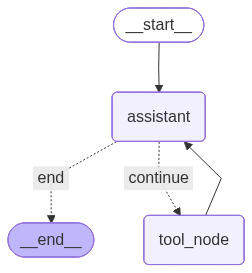

In [36]:
from langgraph.graph import StateGraph, START, END

# Start by defining a builder with our State class
builder = StateGraph(State)

# Add nodes 
builder.add_node("assistant", assistant)
builder.add_node("tool_node", tool_node)


# Add edges 
# First, we define the start node. The query will always route to the assistant node first. 
builder.add_edge(START, "assistant")

# Add in the conditional edge after we call the LLM
builder.add_conditional_edges(
    "assistant",
    should_continue,
    {
        # If `continue`, then we call the tool node.
        "continue": "tool_node",
        # Otherwise we finish.
        "end": END,
    },
)

# Always return to the LLM after calling tools
builder.add_edge("tool_node", "assistant")

agent = builder.compile(name="agent")
agent

We have successfully rebuilt a ReAct agent from scratch identical to the basic one we made using `create_agent`. Let's try it!

In [37]:
from langchain.messages import HumanMessage

question = "What is the weather in SF today, and what are some good Sci-Fi movies?"

result = agent.invoke({"messages": HumanMessage(content=question)})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the weather in SF today, and what are some good Sci-Fi movies?
================================== Ai Message ==================================

[{'text': "I'll help you get the weather for San Francisco and recommend some Sci-Fi movies!", 'type': 'text'}, {'id': 'toolu_01LGiH6yf9QmcoKeoF16RbLJ', 'input': {'latitude': 37.7749, 'longitude': -122.4194}, 'name': 'get_weather', 'type': 'tool_use'}, {'id': 'toolu_019n5ZxkeNynEMvjLDAGyWCV', 'input': {'genre': 'Sci-Fi'}, 'name': 'search_movies', 'type': 'tool_use'}]
Tool Calls:
  get_weather (toolu_01LGiH6yf9QmcoKeoF16RbLJ)
 Call ID: toolu_01LGiH6yf9QmcoKeoF16RbLJ
  Args:
    latitude: 37.7749
    longitude: -122.4194
  search_movies (toolu_019n5ZxkeNynEMvjLDAGyWCV)
 Call ID: toolu_019n5ZxkeNynEMvjLDAGyWCV
  Args:
    genre: Sci-Fi
================================= Tool Message =================================
Name: get_weather

{"temperature_celsius": 

## 🎉 Congratulations!

You've learned the core concepts of building agents with LangChain and LangGraph:

 **Models** - Standardized interface across providers  
 **Messages** - Building block of conversations  
 **Tools** - Extending LLM capabilities  
 **Agents** - Automated reasoning and action loops  
 **Memory** - Maintaining context across interactions  
 **Streaming** - Real-time user experience  
 **LangGraph** - The foundation powering it all

### What's Next?

1. **Build your own agent** with your specific tools and use case
2. **Explore advanced patterns** in the `multi_agent.ipynb` notebook
3. **Add debugging** with [LangSmith](https://smith.langchain.com)
4. **Deploy to production** using LangGraph's persistence and error recovery

### Resources:

- [LangChain Documentation](https://python.langchain.com/docs/introduction/)
- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [LangSmith for Debugging](https://smith.langchain.com)
- [LangChain Academy](https://academy.langchain.com/)
<br> 
<br> 
---
<br> 

**Happy building!**